In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
# import sklearn
# print("sklearn version: ", sklearn.__version__)
# assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

TF version:  2.4.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [37]:
import numpy as np
import pandas as pd
import os
import time
# import scoring as scoring
import pickle
import gzip
from pyarrow import csv
import csv
# train_path = "D:/2022AIComp_data/train.csv"
# test_path = "D:/2022AIComp_data/test.csv"

#---------------------- Load Train,Test DF
train_pd = pd.read_csv("D:/2022AIComp_data/train.csv")
test_pd = pd.read_csv("D:/2022AIComp_data/test.csv")

print("Train: %s, Test: %s" %(train_pd.shape, test_pd.shape))
train_pd.head()
print(train_pd.iloc[:,0].unique())
# test_pd.head()

Train: (33600, 514), Test: (7820, 514)
['out' 'in' 'normal' 'other' 'noise']


In [341]:
def data_shape(data_li,local = None):
    for data in data_li:
        vnames = [name for name in globals() if globals()[name] is data ]
#         print(len(vnames))
        if len(vnames) != 0:
            print(vnames[0],'.shape : ',data.shape)
        else:
            if local == None:
                local = locals()
            vnames = [name for name in local if local[name] is data]
            print(vnames,'.shape : ',data.shape)
            
def remake_data():
    X = np.array(train_pd.iloc[:,1:])
    y = train_pd.iloc[:,0].replace(['out','in', 'normal', 'other', 'noise'],[0,1,2,3,4])
    # y_train = np.argmax(np.array(pd.get_dummies(train_pd.iloc[:,0])),axis=1)

    submit_test = np.array(test_pd.iloc[:,1:])

    # y_test = np.array(pd.get_dummies(test_pd.iloc[:,0]))
    #data Normalize

    return X,y,submit_test
#     from sklearn.model_selection import train_test_split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)
#     data_shape([X_train, X_test ,submit_test])

In [47]:

X = np.array(train_pd.iloc[:,1:1001])
y = train_pd.iloc[:,0].replace(['out','in', 'normal', 'other', 'noise'],[0,1,2,3,4])
# y_train = np.argmax(np.array(pd.get_dummies(train_pd.iloc[:,0])),axis=1)

submit_test = np.array(test_pd.iloc[:,1:1001])

# y_test = np.array(pd.get_dummies(test_pd.iloc[:,0]))
#data Normalize


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)
data_shape([X_train, X_test ,submit_test])

X_train .shape :  (26880, 513)
X_test .shape :  (6720, 513)
submit_test .shape :  (7820, 513)


In [35]:
###in out 만
X_train01 = np.array(train_pd.iloc[:3600,1:])
y_train01 = train_pd.iloc[:3600,0].replace(['out','in', 'normal', 'other', 'noise'],[0,1,2,3,4])
# y_train = np.argmax(np.array(pd.get_dummies(train_pd.iloc[:,0])),axis=1)

submit_test = np.array(test_pd.iloc[:,1:])

# y_test = np.array(pd.get_dummies(test_pd.iloc[:,0]))
#data Normalize


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state = 42, stratify = y_train)
data_shape([X_train, X_test ,submit_test])

X_train .shape :  (21504, 513)
X_test .shape :  (5376, 513)
submit_test .shape :  (7820, 513)


In [124]:
X,y,submit_data = remake_data()
def min_max_scale(X,X_min=0,X_max=0):
    if X_min == 0:
        X_min=min(X[X!=0])
        X_max=max(X[X!=0])
    print(X_min,X_max)
    X_std = (X - X_min) / (X_max -X_min)
    print(np.min( X_std * (X_max -X_min)))
    X_scaled = X_std * (X_max -X_min) + X_min
    print(np.min(X_scaled))
    return X_scaled , X_min,X_max

# print(min_max_scale(X).shape)

In [125]:
#data Normalize
def data_scale(X_train,submit_test):

#     from sklearn.preprocessing import StandardScaler, MinMaxScaler
    # scaler = StandardScaler()
#     scaler = MinMaxScaler()

    X_scaled,X_min,X_max = min_max_scale(X_train)
    X_submit_scaled,X_min,X_max = min_max_scale(submit_test,X_min,X_max)

    print(np.min(X_scaled),np.min(X_submit_scaled))
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state = 42, stratify = y)
    return X_scaled,X_submit_scaled

# X_scaled,submit_test = data_scale(X,submit_test)


1 1623
-1.0
0.0
1 1623
-1.0
0.0
0.0 0.0


(array([ 288.,    0.,  288.,    0.,    0., 2880.,    0., 1120.,    0.,
         800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

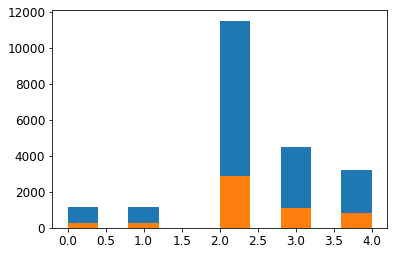

In [88]:
plt.hist(y_train)
plt.hist(y_val)
# plt.xticks(['out','in', 'normal', 'other', 'noise'])

In [189]:
# from datetime import datetime
# c= datetime.now()
# a = c.strftime('%Y-%m-%d_%H_%M')
# print(a)

# import time

# def hms(s):
#     hours = s // 3600
#     s = s - hours*3600
#     mu = s // 60
#     ss = s - mu*60
#     return hours, mu, ss


# ##dense layer 바꿈
# from tensorflow import keras
# from datetime import datetime
# from tensorflow.keras import layers, models
# from sklearn.utils.class_weight import compute_class_weight
# from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
# import time

# #####
# def train_model(model, X_train = X_train, X_test = X_test, y_test = y_test,
#                 batch_size = 128, optimizer='adam',patience=10, matrix = True,
#                 class_weight=True, epoch = 100,reshape = False):

#     c = datetime.now()
#     n_time = c.strftime('%Y-%m-%d_%H_%M')
#     print(n_time)

#     if reshape ==True:
#         X_tr=X_train.reshape((-1,27,19,1))
#         X_te=X_test.reshape((-1,27,19,1))
#     else:
#         X_tr = X_train
#         X_te = X_test
        
#     print(X_tr.shape)
    
#     MODEL_SAVE_FOLDER_PATH = './model/' 
#     if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
#         os.mkdir(MODEL_SAVE_FOLDER_PATH) 
#     model_path = MODEL_SAVE_FOLDER_PATH + str(n_time)+'.hdf5'


#     es = EarlyStopping(monitor='val_loss', mode='min', 
#                        verbose=1, patience=patience, restore_best_weights = True)

#     mc = ModelCheckpoint(model_path, monitor='val_loss',
#                          mode='min', save_best_only=True)

#     if class_weight==True:
#         class_weights = compute_class_weight(class_weight = 'balanced',
#                                                          classes = np.unique(y_train),
#                                                          y = y_train)
#         class_weights = dict(enumerate(class_weights))
#     else:
#         class_weights = None

#     #model compile
#     model.compile(loss='sparse_categorical_crossentropy',
#                           optimizer = optimizer
#                          ,metrics=['accuracy'])


#     start = time.time()

#     #model fit
#     history = model.fit(X_tr,y_train, epochs = epoch,
#                      batch_size=batch_size, validation_split=0.2, 
#                                 callbacks=[es, mc],
#                                class_weight = class_weights,
#                                 shuffle=True,
#                        ).history

#     terminate_time = time.time() - start
#     # training time
#     hours, mu, ss = hms(terminate_time)
#     print('training time: ', hours, 'h', mu, 'm', ss, 's')    
#     print('\n-----test score : ',model.evaluate(X_te, y_test))
    
    
#     plt.plot(history['accuracy'], label='train_acc')
#     plt.plot(history['val_accuracy'], label= 'val_acc')
#     plt.plot(history['loss'], label= 'train_loss')
#     plt.plot(history['val_loss'], label= 'val_loss')
#     plt.title('Learning Curve')
#     plt.xlabel('Epoch')
#     plt.legend(loc='lower left')
#     plt.show()
    
#     print_acc(model,X_te, y_test, matrix)
#     submit_pd = make_test_csv(model,model_name = n_time, reshape=reshape)
#     return submit_pd

# # inference     
# import seaborn as sns
# from sklearn.metrics import confusion_matrix


# def print_acc(model, X_te, y_test=y_test, matrix =True):
#     y_pred = np.argmax(model.predict(X_te),axis =1)
#     cf = confusion_matrix(y_test, y_pred)

#     per_cf =[]
#     for i in cf:
#         per_cf.append(i/np.sum(i))
#     axes=[]
# #     plt.rc('font', size=10)
#     for i , cf in enumerate([cf, per_cf]):
#         fig=plt.figure(figsize=(8,8))
#         axes.append(fig.add_subplot(2,2,i+1))
#         ax = sns.heatmap(np.round(cf,4),annot=True, fmt='', cmap='Blues')#확률로 표시
#         ax.set_title('Seaborn Confusion Matrix with labels\n\n');
#         ax.set_xlabel('\nPredicted Values')
#         ax.set_ylabel('Actual Values ');
#         fig.tight_layout()
#         ## Display the visualiztion of the Confusion Matrix.
#         plt.show()
        
        
# def make_test_csv(model,model_name,reshape=False):
#     sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
#     sample_pd.set_index('id',inplace=True)
    
#     if reshape == True:
#         submit_te = submit_test.reshape((-1,27,19,1))
#     else:
#         submit_te=submit_test
#     pred = np.argmax(model.predict(submit_te),axis = 1)
#     print(pred.shape)
#     sub = pd.concat([test_pd.iloc[:,0],
#                            pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
#     sub.set_index('id',inplace=True)
#     submit_pd = sub.reindex(sample_pd.index)
#     print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
#     plt.hist(np.array(submit_pd))
#     plt.show()
    
#     MODEL_SAVE_FOLDER_PATH = './result_csv/' 
#     if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
#         os.mkdir(MODEL_SAVE_FOLDER_PATH) 
#     submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[:-5]+'.csv')
#     print(model_name)
#     return submit_pd
    

    
# def load_model_list():
#     for dirname,_, filenames in os.walk('./model'):
#         model_list= filenames
#         print(filenames)

2022-06-19_14_00


In [338]:
from datetime import datetime
c= datetime.now()
a = c.strftime('%Y-%m-%d_%H_%M')
print(a)

import time

def hms(s):
    hours = s // 3600
    s = s - hours*3600
    mu = s // 60
    ss = s - mu*60
    return hours, mu, ss


##dense layer 바꿈
from tensorflow import keras
from datetime import datetime
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

#####
def train_model(model,X_train=X_train,y_train = y_train,
                X_test=X_test,y_test=y_test, batch_size = 128,
                optimizer='adam',patience=10, matrix = True,
                class_weight=True, epoch = 100,reshape = False, make_csv = False,
               label_encoder = False):

    c = datetime.now() ##모델 돌릴 때 시작 시간
    n_time = c.strftime('%Y-%m-%d_%H_%M')
    print(n_time)

    
    if reshape ==True: ##데이터 reshape -> 1d 로 돌릴때
        X_tr=X_train.reshape((-1,X_train.shape[1],X_train.shape[2],1))
        X_te=X_test.reshape((-1,X_test.shape[1],X_test.shape[2],1))
    else:
        X_tr = X_train
        X_te = X_test
        
    print('train_model 안에서')
    local = locals()
    data_shape([X_tr,X_te,y_train,y_test],local)
    
    
    MODEL_SAVE_FOLDER_PATH = './model_4/'  #모델 저장 경로
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    model_path = MODEL_SAVE_FOLDER_PATH + str(n_time)+'.hdf5'


    es = EarlyStopping(monitor='val_loss', mode='min', 
                       verbose=1, patience=patience, restore_best_weights = True)

    mc = ModelCheckpoint(model_path, monitor='val_loss',
                         mode='min', save_best_only=True)
    
    
    if class_weight==True:
        if label_encoder == True:
            classes_in = np.unique(np.argmax(y_train,axis =1))
        else:
            classes_in = np.unique(y_train)
            
            class_weights = compute_class_weight(class_weight = 'balanced',
                                                             classes = classes_in,
                                                             y = y_train)
            class_weights = dict(enumerate(class_weights))
    else:
        class_weights = None

    
    if label_encoder == True:
        loss='categorical_crossentropy'
    else:
        loss='sparse_categorical_crossentropy'
        
    model.compile(loss=loss,
                          optimizer = optimizer
                         ,metrics=['accuracy'])


    start = time.time()

    #model fit
    history = model.fit(X_tr,y_train, epochs = epoch,
                     batch_size=batch_size, validation_split=0.2, 
                                callbacks=[es, mc],
                               class_weight = class_weights,
                                shuffle=True,
                       ).history

    terminate_time = time.time() - start
    
    # training time
    hours, mu, ss = hms(terminate_time)
    print('training time: ', hours, 'h', mu, 'm', ss, 's')    
    print('\n-----test score : ',model.evaluate(X_te, y_test))
    
    #러닝 커브
    plt.plot(history['accuracy'], label='train_acc')
    plt.plot(history['val_accuracy'], label= 'val_acc')
    plt.plot(history['loss'], label= 'train_loss')
    plt.plot(history['val_loss'], label= 'val_loss')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.legend(loc='lower left')
    plt.show()
    
    
    y_pred = print_acc(model, matrix=True ,X_te=X_test,y_test=y_test, reshape = reshape,
             label_encoder=True)
    
    if(make_csv == True):
        submit_pd = make_test_csv(model,submit_test,model_name = n_time, reshape=reshape)
        return submit_pd
    else:
        submit_pd = None

    return y_pred,submit_pd
    
# inference     
import seaborn as sns
from sklearn.metrics import confusion_matrix


def print_acc(model, matrix =True, X_te=X_test,y_test=y_test,reshape = False,
             label_encoder = False):
    
    if reshape ==True: ##데이터 reshape -> cnn 돌릴때
        X_te=X_test.reshape((-1,X_te.shape[1],X_te.shape[2],1))
    else:
        X_te = X_te
        
    data_shape([X_te])
    
    y_pred = model.predict(X_te)
    show_matrix(y_test,y_pred,label_encoder = label_encoder)

    return y_pred
        
        
def make_test_csv(model,submit_test,model_name,reshape=False):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
    pred = np.argmax(model.predict(submit_te),axis = 1)
    print(pred.shape)
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)
    print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
    plt.hist(np.array(submit_pd))
    plt.show()
    
    MODEL_SAVE_FOLDER_PATH = './result_csv/' 
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[:-5]+'.csv')
    print(model_name)
    return submit_pd
    

    
def load_model_list(dir_name):
    for dirname,_, filenames in os.walk(dir_name):
        model_list= filenames
        print(filenames) 
        
        
def show_matrix(y_test,y_pred,label_encoder=False):
    y_pred = np.argmax(y_pred,axis =1)
    if label_encoder == True:
        y_test = np.argmax(y_test,axis =1)
    
    cf = confusion_matrix(y_test, y_pred)

    per_cf =[]
    for i in cf:
        per_cf.append(i/np.sum(i))
    axes=[]
#     plt.rc('font', size=10)
    for i , cf in enumerate([cf, per_cf]):
        fig=plt.figure(figsize=(8,8))
        axes.append(fig.add_subplot(2,2,i+1))
        ax = sns.heatmap(np.round(cf,4),annot=True, fmt='', cmap='Blues')#확률로 표시
        ax.set_title('Seaborn Confusion Matrix with labels\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');
        fig.tight_layout()
        ## Display the visualiztion of the Confusion Matrix.
        plt.show()

2022-06-19_16_19


In [13]:
#LeNet-5 구조
batch_size = 64

input_layer = keras.Input(shape = (513,1))
x=
x=keras.layers.Conv1D(16, kernel_size=7, activation='relu', padding='same')(input_layer) #C11
x=keras.layers.Conv1D(32, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(84, activation='relu')(x)
out = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer,out)
model.summary()

train_model(model,batch_size,patience = 10,optimizer = 'adam')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 513, 1)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 513, 16)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 509, 32)           2592      
_________________________________________________________________
flatten_1 (Flatten)          (None, 16288)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 84)                1368276   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 425       
Total params: 1,371,421
Trainable params: 1,371,421
Non-trainable params: 0
_________________________________________________

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 513)               2052      
_________________________________________________________________
dense_17 (Dense)             (None, 100)               51400     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100)               400       
_________________________________________________________________
dense_18 (Dense)             (None, 300)               30300     
_________________________________________________________________
batch_normalization_12 (Batc (None, 300)               1200      
_________________________________________________________________
dense_19 (Dense)             (None, 84)                25284     
_________________________________________________________________
dense_20 (Dense)             (None, 5)                

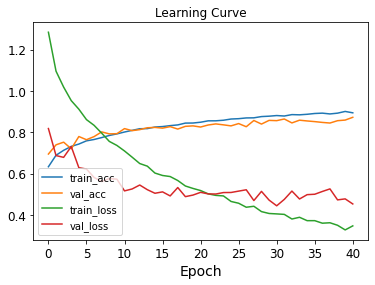

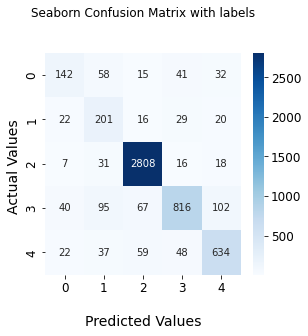

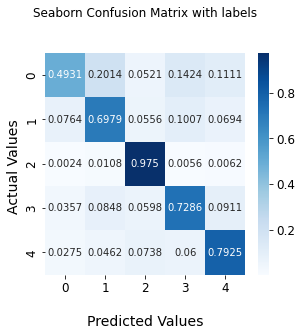

(7820,)
클래스 별 분포 :  leaktype
normal      2734
in          1693
out         1252
noise       1072
other       1069
dtype: int64
2022-06-14_


,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,in
2LgOPmQb8u,normal
b6zEYLjs7Y,noise
yaYY68O0xX,normal
...,...
ljOCzcR8HX,out
SdKATDrV3C,in
Lo3sZiFiew,noise


In [125]:
#LeNet-5 구조
batch_size = 64


model = keras.models.Sequential([
keras.layers.Input(shape=(513,)),
keras.layers.BatchNormalization(),
keras.layers.Dense(100, activation='relu'), #C11
keras.layers.BatchNormalization(),
keras.layers.Dense(300,activation='relu'), #C3
keras.layers.BatchNormalization(),
keras.layers.Dense(84, activation='relu'), #F6
keras.layers.Dense(5, activation='softmax')])



model.summary()

train_model(model,batch_size,patience = 10,optimizer = 'adam')

submit_pd = train_model_conti(model,batch_size,patience = 10,optimizer = 'adam')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               51400     
_________________________________________________________________
dense_22 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_23 (Dense)             (None, 84)                25284     
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 425       
Total params: 107,409
Trainable params: 107,409
Non-trainable params: 0
_________________________________________________________________
2022-06-14_16_36
Epoch 1/100
336/336 [==============================] - 2s 6ms/step - loss: 3.8756 - accuracy: 0.3966 - val_loss: 1.0580 - val_accuracy: 0.6845
Epoch 2/100
336/336 [==============================] - 2s 5ms/step - loss: 1.1910 - ac

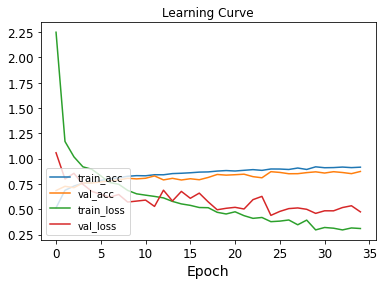

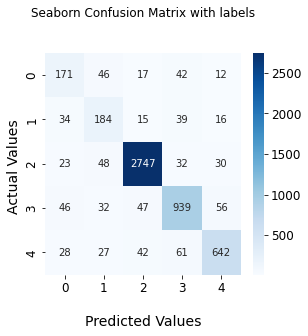

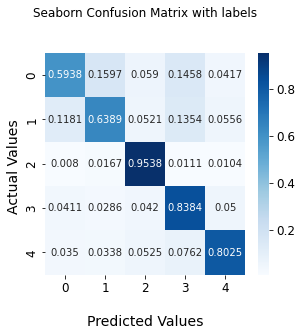

(7820,)
클래스 별 분포 :  leaktype
normal      2601
out         1598
in          1513
other       1290
noise        818
dtype: int64


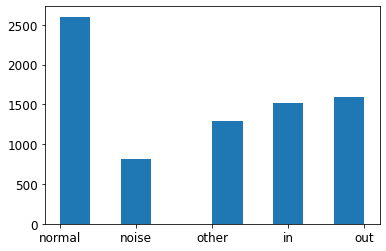

2022-06-14_16_36


,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,noise
2LgOPmQb8u,normal
b6zEYLjs7Y,other
yaYY68O0xX,normal
...,...
ljOCzcR8HX,out
SdKATDrV3C,out
Lo3sZiFiew,noise


In [130]:
#LeNet-5 구조
batch_size = 64


model = keras.models.Sequential([
keras.layers.Input(shape=(513,)),
keras.layers.Dense(100, activation='relu'), #C11
keras.layers.Dense(300,activation='relu'), #C3
keras.layers.Dense(84, activation='relu'), #F6
keras.layers.Dense(5, activation='softmax')])



model.summary()

train_model(model,batch_size,patience = 10,optimizer = 'adam')


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 513)               2052      
_________________________________________________________________
dense_33 (Dense)             (None, 100)               51400     
_________________________________________________________________
batch_normalization_20 (Batc (None, 100)               400       
_________________________________________________________________
dense_34 (Dense)             (None, 300)               30300     
_________________________________________________________________
batch_normalization_21 (Batc (None, 300)               1200      
_________________________________________________________________
dense_35 (Dense)             (None, 84)                25284     
_________________________________________________________________
dense_36 (Dense)             (None, 5)                

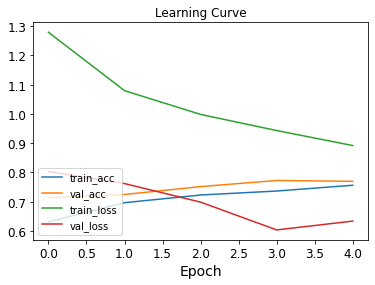

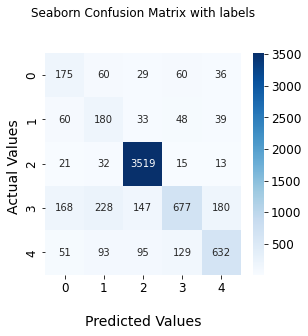

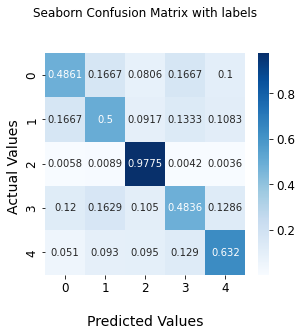

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
normal      2829
out         1501
in          1438
other       1070
noise        982
dtype: int64


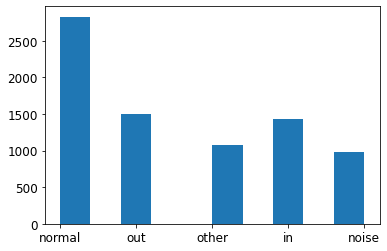

2022-06-14_17_10


In [142]:
#LeNet-5 구조
batch_size = 64


model = keras.models.Sequential([
keras.layers.Input(shape=(513,)),
keras.layers.BatchNormalization(),
keras.layers.Dense(100, activation='relu'), #C11
keras.layers.BatchNormalization(),
keras.layers.Dense(300,activation='relu'), #C3
keras.layers.BatchNormalization(),
keras.layers.Dense(84, activation='relu'), #F6
keras.layers.Dense(5, activation='softmax')])



model.summary()

submit_pd = train_model(model,batch_size,patience = 1,optimizer = 'adam')

train_model(model,batch_size,patience = 10,optimizer = 'adam')


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 27, 19, 6)         156       
_________________________________________________________________
batch_normalization_52 (Batc (None, 27, 19, 6)         24        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 9, 6)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 13, 9, 16)         2416      
_________________________________________________________________
batch_normalization_53 (Batc (None, 13, 9, 16)         64        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 4, 16)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 6, 4, 120)       

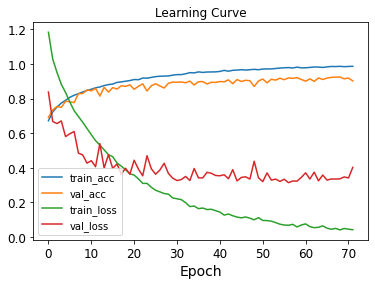

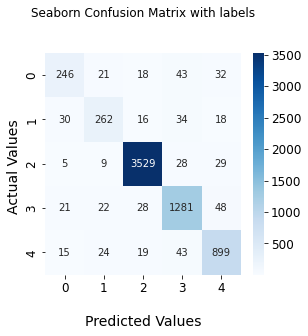

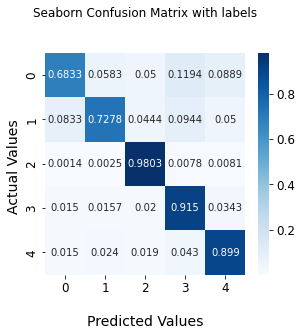

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
normal      2607
out         1576
in          1394
other       1285
noise        958
dtype: int64


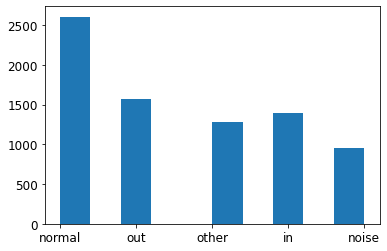

2022-06-14_18_10


,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,out
2LgOPmQb8u,normal
b6zEYLjs7Y,other
yaYY68O0xX,normal
...,...
ljOCzcR8HX,out
SdKATDrV3C,out
Lo3sZiFiew,noise


In [165]:
batch_size= 64
X_train
model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(5, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,batch_size,patience = 15,optimizer = 'sgd',reshape=True)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_55 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_56 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 6, 4, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 6, 4, 120)       

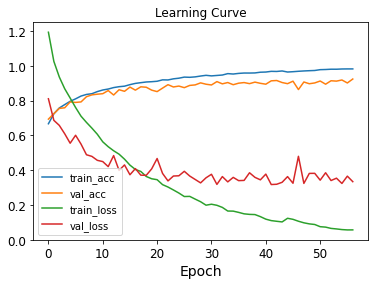

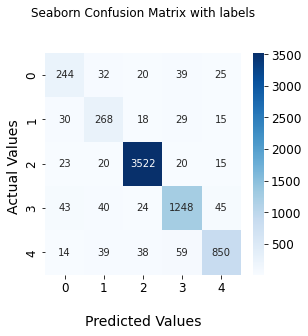

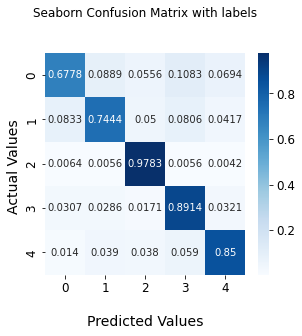

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
normal      2597
out         1750
in          1466
other       1210
noise        797
dtype: int64


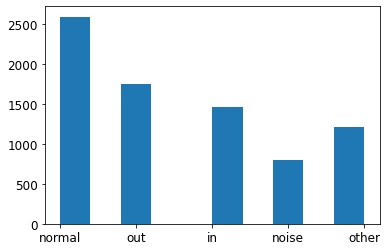

2022-06-14_18_14


,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,out
2LgOPmQb8u,normal
b6zEYLjs7Y,out
yaYY68O0xX,normal
...,...
ljOCzcR8HX,out
SdKATDrV3C,in
Lo3sZiFiew,noise


In [167]:
batch_size= 64
X_train
model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(5, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,batch_size,patience = 15,optimizer = 'sgd',reshape=True)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_58 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_59 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_60 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 4, 64)        

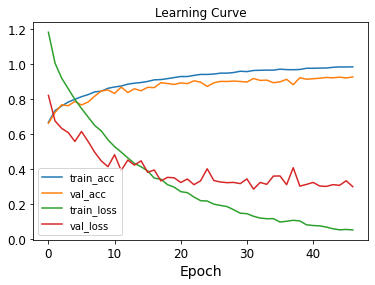

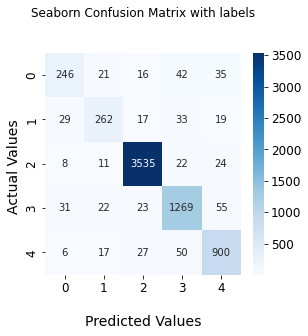

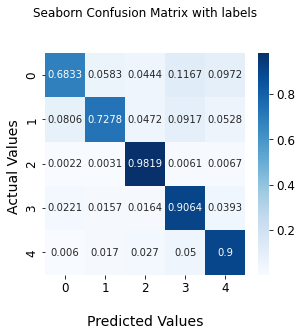

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
normal      2614
out         1715
in          1317
other       1235
noise        939
dtype: int64


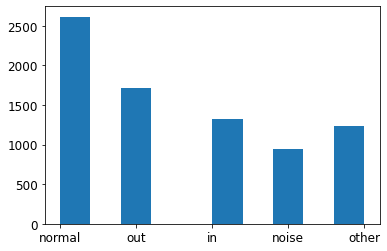

2022-06-14_18_21


,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,out
2LgOPmQb8u,normal
b6zEYLjs7Y,out
yaYY68O0xX,normal
...,...
ljOCzcR8HX,out
SdKATDrV3C,in
Lo3sZiFiew,noise


In [168]:
batch_size= 64
X_train
model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(5, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,batch_size,patience = 15,optimizer = 'sgd',reshape=True)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_62 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_63 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_64 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 4, 64)        

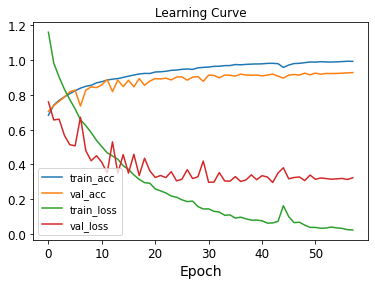

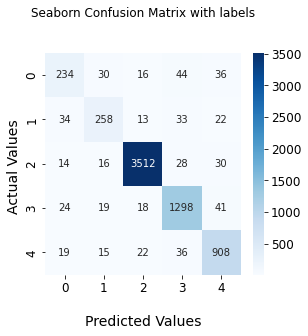

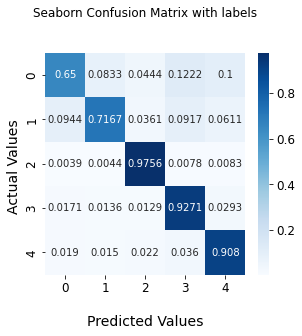

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
normal      2563
out         1753
in          1367
other       1242
noise        895
dtype: int64


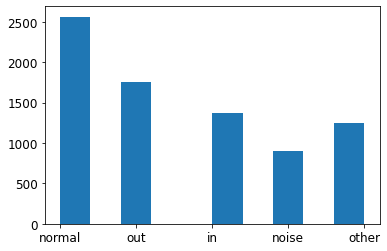

2022-06-14_18_33


,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,out
2LgOPmQb8u,normal
b6zEYLjs7Y,out
yaYY68O0xX,normal
...,...
ljOCzcR8HX,out
SdKATDrV3C,out
Lo3sZiFiew,noise


In [169]:
batch_size= 64
X_train
model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(5, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,batch_size,patience = 15,optimizer = 'sgd',reshape=True,class_weight=True)

In [49]:
def data_reshape(data, shape):
    X_train=data[0].reshape(shape)
    X_test=data[1].reshape(shape)
    submit_test=data[2].reshape(shape)
    return X_train, X_test, submit_test

X_train
X_train .shape :  (26880, 10, 10, 1)
X_test
X_test .shape :  (6720, 10, 10, 1)
submit_test
submit_test .shape :  (7820, 10, 10, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_24 (Batc (None, 10, 10, 1)         4         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 16)        416       
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 5, 5, 64)          25664     
_________________________________________________________________
batch_normalization_26 (Batc (None, 5, 5, 64)  

336/336 [==============================] - 2s 7ms/step - loss: 0.1164 - accuracy: 0.9642 - val_loss: 0.3510 - val_accuracy: 0.9009
Epoch 43/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0986 - accuracy: 0.9705 - val_loss: 0.3417 - val_accuracy: 0.9020
Epoch 44/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0937 - accuracy: 0.9705 - val_loss: 0.3606 - val_accuracy: 0.9005
Epoch 45/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0939 - accuracy: 0.9685 - val_loss: 0.3423 - val_accuracy: 0.9051
Epoch 46/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0952 - accuracy: 0.9723 - val_loss: 0.3506 - val_accuracy: 0.9090
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
training time:  0.0 h 1.0 m 40.516761302948 s
210/210 [==============================] - 1s 3ms/step - loss: 0.3157 - accuracy: 0.9039

-----test score :  [0.3157195448875427, 0.9038690328598022]


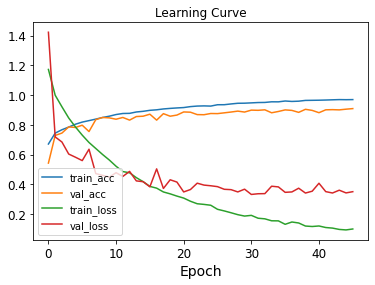

X_test
X_test .shape :  (6720, 10, 10, 1)


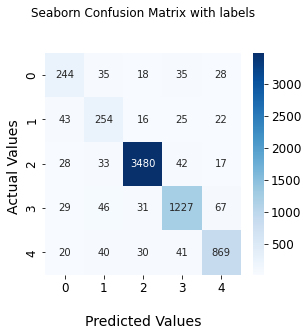

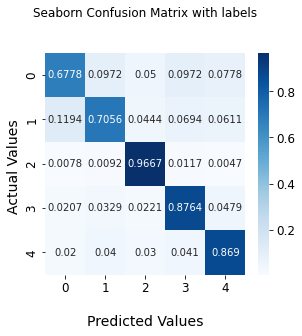

In [78]:
#1000Hz 미만으로
batch_size= 64
X,y,submit_test = remake_data()

X_scaled,submit_test = data_scale(X,submit_test)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state = 42, stratify = y)

X_train, X_test , submit_test =data_reshape(
    [X_train[:,:100],X_test[:,:100],submit_test[:,:100]],(-1,10,10,1))

data_shape([X_train,X_test,submit_test])

input_shape = (X_train.shape[1],X_train.shape[2],1)
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(5, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train=X_train,X_test=X_test,
            batch_size=batch_size,patience = 15,optimizer = 'sgd',reshape=False,class_weight=True)

1 1623
-1.0
0.0
1 1623
-1.0
0.0
0.0 0.0
X_train
X_train .shape :  (26880, 10, 10, 1)
X_test
X_test .shape :  (6720, 10, 10, 1)
submit_test
submit_test .shape :  (7820, 10, 10, 1)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_44 (Batc (None, 10, 10, 1)         4         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 10, 10, 16)        416       
_________________________________________________________________
batch_normalization_45 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 5, 5, 64)          25664     
_________________________________________________________________
batch_

336/336 [==============================] - 2s 7ms/step - loss: 0.2069 - accuracy: 0.9396 - val_loss: 0.4085 - val_accuracy: 0.8692
Epoch 43/100
336/336 [==============================] - 2s 7ms/step - loss: 0.1930 - accuracy: 0.9413 - val_loss: 0.3695 - val_accuracy: 0.8930
Epoch 44/100
336/336 [==============================] - 2s 7ms/step - loss: 0.1798 - accuracy: 0.9475 - val_loss: 0.3669 - val_accuracy: 0.8810
Epoch 45/100
336/336 [==============================] - 2s 7ms/step - loss: 0.1730 - accuracy: 0.9457 - val_loss: 0.3651 - val_accuracy: 0.8845
Epoch 46/100
336/336 [==============================] - 2s 7ms/step - loss: 0.1963 - accuracy: 0.9455 - val_loss: 0.3824 - val_accuracy: 0.8878
Epoch 47/100
336/336 [==============================] - 2s 7ms/step - loss: 0.1677 - accuracy: 0.9512 - val_loss: 0.3678 - val_accuracy: 0.8897
Epoch 48/100
336/336 [==============================] - 2s 7ms/step - loss: 0.1545 - accuracy: 0.9499 - val_loss: 0.3899 - val_accuracy: 0.8774
Epoch

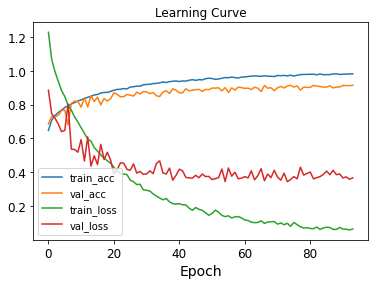

X_test
X_test .shape :  (6720, 10, 10, 1)


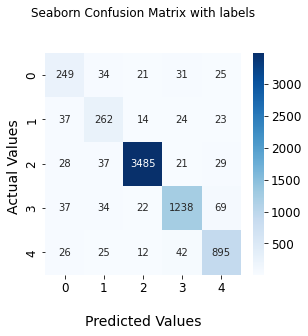

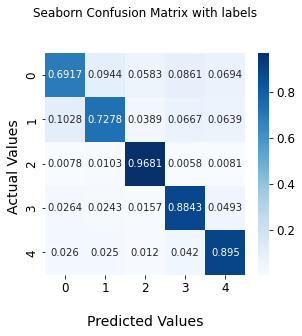

In [140]:
#1000Hz 미만으로 min-max custom
batch_size= 64
X,y,submit_test = remake_data()

X_scaled,submit_test = data_scale(X,submit_test)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state = 42, stratify = y)

X_train, X_test , submit_test =data_reshape(
    [X_train[:,:100],X_test[:,:100],submit_test[:,:100]],(-1,10,10,1))

data_shape([X_train,X_test,submit_test])

input_shape = (X_train.shape[1],X_train.shape[2],1)
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(5, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train=X_train,X_test=X_test,
            batch_size=batch_size,patience = 20,optimizer = 'sgd',reshape=False,class_weight=True)

In [138]:
def make_test_csv(model,submit_test,model_name,reshape=False):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
    pred = np.argmax(model.predict(submit_te),axis = 1)
    print(pred.shape)
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)
    print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
    plt.hist(np.array(submit_pd))
    plt.show()
    
    MODEL_SAVE_FOLDER_PATH = './result_csv/' 
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[:-5]+'.csv')
    print(model_name)
    return submit_pd

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
normal      2561
out         1772
in          1466
other       1127
noise        894
dtype: int64


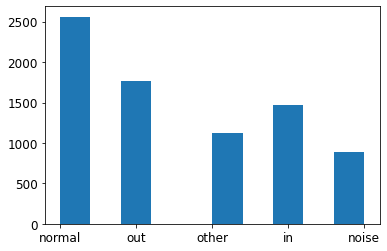

1000_min_max


,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,out
2LgOPmQb8u,normal
b6zEYLjs7Y,other
yaYY68O0xX,normal
...,...
ljOCzcR8HX,out
SdKATDrV3C,other
Lo3sZiFiew,noise


In [141]:
model_name = '1000_min_max'
make_test_csv(model,submit_test,model_name,False)

X_train
X_train .shape :  (26880, 320)
X_test
X_test .shape :  (6720, 320)
submit_test
submit_test .shape :  (7820, 320)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_91 (Batc (None, 20, 16, 1)         4         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 20, 16, 16)        416       
_________________________________________________________________
batch_normalization_92 (Batc (None, 20, 16, 16)        64        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 10, 8, 16)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 10, 8, 64)         25664     
_________________________________________________________________
batch_normalization_93 (Batc (None, 10, 8, 64)         256      

336/336 [==============================] - 2s 6ms/step - loss: 0.0662 - accuracy: 0.9787 - val_loss: 0.3328 - val_accuracy: 0.9092
Epoch 44/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0776 - accuracy: 0.9780 - val_loss: 0.3341 - val_accuracy: 0.9107
Epoch 45/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0656 - accuracy: 0.9792 - val_loss: 0.3297 - val_accuracy: 0.9083
Epoch 46/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0763 - accuracy: 0.9802 - val_loss: 0.3670 - val_accuracy: 0.9126
Epoch 47/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0599 - accuracy: 0.9813 - val_loss: 0.2928 - val_accuracy: 0.9295
Epoch 48/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0459 - accuracy: 0.9858 - val_loss: 0.3112 - val_accuracy: 0.9209
Epoch 49/100
336/336 [==============================] - 2s 6ms/step - loss: 0.0432 - accuracy: 0.9878 - val_loss: 0.2845 - val_accuracy: 0.9319
Epoch

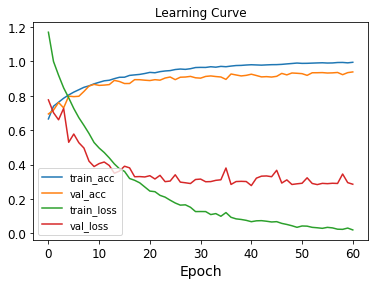

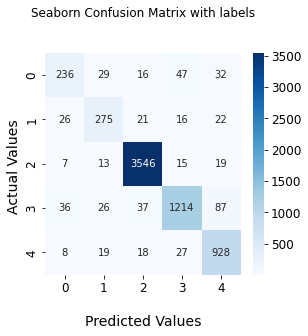

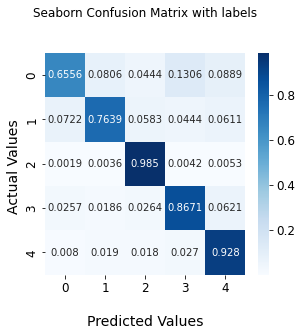

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
normal      2629
out         1712
in          1405
other       1080
noise        994
dtype: int64


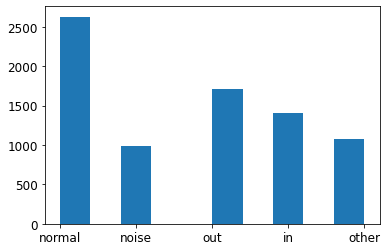

2022-06-19_14_13


,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,noise
2LgOPmQb8u,normal
b6zEYLjs7Y,out
yaYY68O0xX,normal
...,...
ljOCzcR8HX,out
SdKATDrV3C,in
Lo3sZiFiew,noise


In [204]:
#feature 뽑아서 normal x 
batch_size= 64
X,y,submit_test = remake_data()

X=np.concatenate((X[:,1:140],X[:,240:321],X[:,400:500]),axis = 1)
submit_test=np.concatenate((submit_test[:,1:140],submit_test[:,240:321],submit_test[:,400:500]),axis = 1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

data_shape([X_train,X_test,submit_test])

X_train, X_test , submit_test =data_reshape(
    [X_train,X_test,submit_test],(-1,20,16,1))


input_shape = (X_train.shape[1],X_train.shape[2],1)
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(5, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train=X_train,X_test=X_test,
            batch_size=batch_size,patience = 20,optimizer = 'sgd',reshape=False,class_weight=True)

X_train
X_train .shape :  (2880, 320)
X_test
X_test .shape :  (720, 320)
submit_test
submit_test .shape :  (7820, 320)
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_120 (Bat (None, 20, 16, 1)         4         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 20, 16, 16)        416       
_________________________________________________________________
batch_normalization_121 (Bat (None, 20, 16, 16)        64        
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 10, 8, 16)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 10, 8, 64)         25664     
_________________________________________________________________
batch_normalization_122 (Bat (None, 10, 8, 64)         256       


Epoch 44/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0485 - accuracy: 0.9877 - val_loss: 0.4189 - val_accuracy: 0.8333
Epoch 45/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0526 - accuracy: 0.9848 - val_loss: 0.4326 - val_accuracy: 0.8368
Epoch 46/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0518 - accuracy: 0.9842 - val_loss: 0.4892 - val_accuracy: 0.8333
Epoch 47/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0606 - accuracy: 0.9834 - val_loss: 0.4346 - val_accuracy: 0.8472
Epoch 48/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0372 - accuracy: 0.9913 - val_loss: 0.4398 - val_accuracy: 0.8368
Epoch 49/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0442 - accuracy: 0.9880 - val_loss: 0.4031 - val_accuracy: 0.8611
Epoch 50/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0325 - accuracy: 0.9959 - val_loss: 0.4207 - val_accuracy: 0.8438
Epoch 

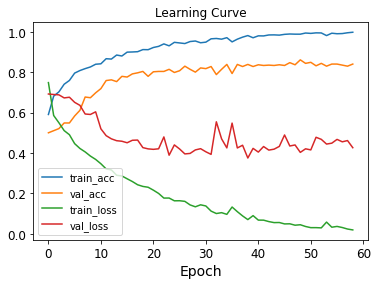

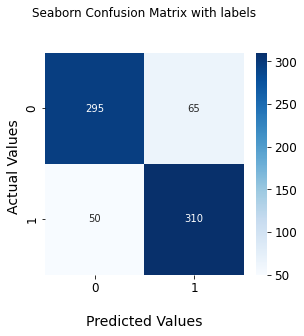

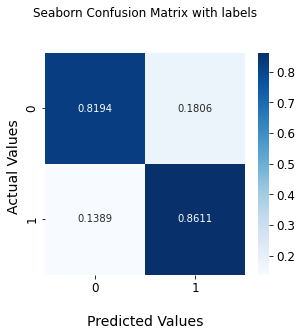

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
out         4342
in          3478
dtype: int64


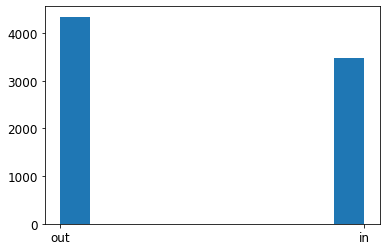

2022-06-19_14_27


,leaktype
id,
gAbuQeZQCm,out
4xtuwcJQI7,out
2LgOPmQb8u,in
b6zEYLjs7Y,out
yaYY68O0xX,out
...,...
ljOCzcR8HX,out
SdKATDrV3C,out
Lo3sZiFiew,out


In [215]:
#feature 뽑아서 normal x , in,out 만
batch_size= 64
X,y,submit_test = remake_data()

X=np.concatenate((X[:3600,1:140],X[:3600,240:321],X[:3600,400:500]),axis = 1)
submit_test=np.concatenate((submit_test[:,1:140],submit_test[:,240:321],submit_test[:,400:500]),axis = 1)
y= y[:3600]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

data_shape([X_train,X_test,submit_test])

X_train, X_test , submit_test =data_reshape(
    [X_train,X_test,submit_test],(-1,20,16,1))


input_shape = (X_train.shape[1],X_train.shape[2],1)
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(2, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train=X_train,X_test=X_test,y_test = y_test,
            batch_size=batch_size,patience = 20,optimizer = 'sgd',reshape=False,class_weight=True)

X_train
X_train .shape :  (2880, 513)
X_test
X_test .shape :  (720, 513)
submit_test
submit_test .shape :  (7820, 513)
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_116 (Bat (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_117 (Bat (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_118 (Bat (None, 13, 9, 64)         256       


Epoch 44/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0355 - accuracy: 0.9920 - val_loss: 0.4577 - val_accuracy: 0.8438
Epoch 45/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0448 - accuracy: 0.9852 - val_loss: 0.4690 - val_accuracy: 0.8385
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
training time:  0.0 h 0.0 m 17.50211501121521 s
23/23 [==============================] - 0s 5ms/step - loss: 0.3717 - accuracy: 0.8472

-----test score :  [0.371673583984375, 0.8472222089767456]


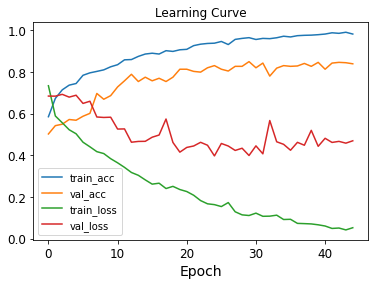

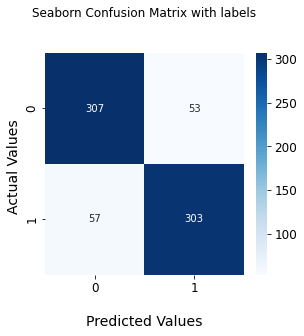

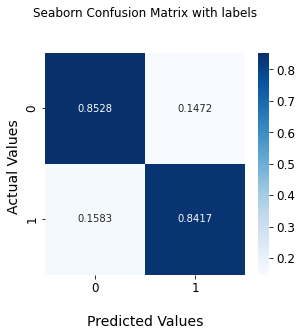

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
out         4422
in          3398
dtype: int64


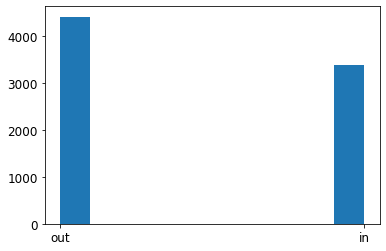

2022-06-19_14_26


,leaktype
id,
gAbuQeZQCm,out
4xtuwcJQI7,out
2LgOPmQb8u,out
b6zEYLjs7Y,out
yaYY68O0xX,out
...,...
ljOCzcR8HX,out
SdKATDrV3C,out
Lo3sZiFiew,out


In [213]:
#feature 뽑아서 normal x , in,out 만
batch_size= 64
X,y,submit_test = remake_data()

# X=np.concatenate((X[:3600,1:140],X[:3600,240:321],X[:3600,400:500]),axis = 1)
# submit_test=np.concatenate((submit_test[:,1:140],submit_test[:,240:321],submit_test[:,400:500]),axis = 1)
X=X[:3600]
y= y[:3600]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

data_shape([X_train,X_test,submit_test])

X_train, X_test , submit_test =data_reshape(
    [X_train,X_test,submit_test],(-1,27,19,1))


input_shape = (X_train.shape[1],X_train.shape[2],1)
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(64, activation='relu'), #F6
    keras.layers.Dense(2, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train=X_train,X_test=X_test,y_test = y_test,
            batch_size=batch_size,patience = 20,optimizer = 'sgd',reshape=False,class_weight=True)

In [354]:
#feature 뽑아서 normal x , in,out 만
batch_size= 64
X,y,submit_test = remake_data()

# X=np.concatenate((X[:3600,1:140],X[:3600,240:321],X[:3600,400:500]),axis = 1)
# submit_test=np.concatenate((submit_test[:,1:140],submit_test[:,240:321],submit_test[:,400:500]),axis = 1)
X=X[-12000:]
y= y[-12000:]
y=np.array(pd.get_dummies(y))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)
# y_train = ohe.fit_transform(y_train.values.reshape(-1,1))



X_train, X_test , submit_test =data_reshape(
    [X_train,X_test,submit_test],(-1,27,19,1))
data_shape([X_train,X_test,submit_test,y_train,y_test])

print(np.unique(y))

# input_shape = (X_train.shape[1],X_train.shape[2],1)
# model = keras.models.Sequential([
#     keras.Input(shape=input_shape),
#     layers.BatchNormalization(),
# #     keras.layers.experimental.preprocessing.Resizing(32,32),
#     keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
#     layers.BatchNormalization(),
#     keras.layers.Flatten(), #Flatten    
#     keras.layers.Dense(64, activation='relu'), #F6
#     keras.layers.Dense(2, activation='softmax') #Output layer
#     ])


input_layer = keras.Input(shape = (515,1))
x=keras.layers.Conv1D(16, kernel_size=5,strides=1,  activation='relu', padding='same')(input_layer) #C11
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(64, kernel_size=5, strides=4, activation='relu', padding='valid')(x)
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(128, kernel_size=5, strides=1, activation='tanh', padding='valid')(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(84, activation='tanh')(x)
out = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer,out)
model.summary()



model.summary()
y_pred, submit = train_model(model,X_train=X_train,X_test=X_test,y_test = y_test,
            batch_size=batch_size,patience = 20,optimizer = 'sgd',reshape=False,
            class_weight=False,label_encoder = True)

X_train .shape :  (9600, 27, 19, 1)
X_test .shape :  (2400, 27, 19, 1)
submit_test .shape :  (7820, 27, 19, 1)
y_train .shape :  (9600, 2)
y_test .shape :  (2400, 2)
[0 1]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 515, 1)]          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 515, 16)           96        
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 257, 16)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 64, 64)            5184      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 32, 64)            0         
_________________________________________________________________
conv1d_36 (Conv1D)   

ValueError: in user code:

    C:\Users\GJ\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\GJ\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\GJ\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\GJ\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\GJ\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\GJ\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\GJ\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\GJ\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\GJ\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 515, 1), found shape=(64, 27, 19, 1)


In [352]:
np.argmax(y_test,axis=1)


ValueError: Shape of passed values is (2400, 1), indices imply (2400, 2)

X_test
X_test .shape :  (2400, 27, 19, 1)


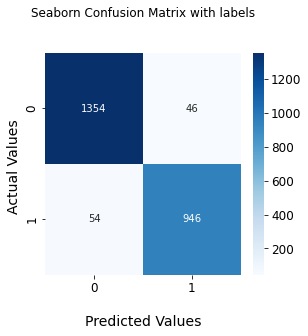

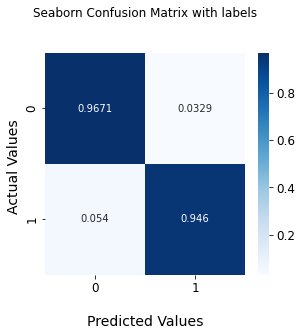

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [258]:
print_acc(model, matrix=True ,X_te=X_test,y_test=y_test,label_encoder=True)

In [295]:
#feature 뽑아서 normal x , in,out 만
batch_size= 64
X,y,submit_test = remake_data()

# X=np.concatenate((X[:3600,1:140],X[:3600,240:321],X[:3600,400:500]),axis = 1)
# submit_test=np.concatenate((submit_test[:,1:140],submit_test[:,240:321],submit_test[:,400:500]),axis = 1)
# X=X[-12000:]
# y= y[-12000:]

y=pd.get_dummies(y)

# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse = False)
# y = ohe.fit_transform(y.values.reshape(-1,1))
print(y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)
# y_train = ohe.fit_transform(y_train.values.reshape(-1,1))

(33600, 5)


In [297]:
y_test.shape

(6720, 5)

In [303]:
pred

array([0, 4, 4, ..., 4, 2, 3], dtype=int64)

In [302]:
def change_test_result(model_name,pred,X_test = X_test, label = y_test,CL = [],matrix=True):
    
    model = tf.keras.models.load_model('./model_4/'+model_name+'.hdf5')
    
    show_matrix(label,pred,label_encoder = True)
    print(label,pred)
    CL_ind_li = []
    for i in CL:
        CL_ind_Li.append(np.where(pred==i)[0])# step 2에 들어갈 X_test index
        CL_test = submit_te[submit_te_4_ind] #step 2에 들어갈 X_test
    
    pred_2 = np.argmax(model_2.predict(submit_te_4),axis = 1)

model_name = '2022-06-19_15_23'
change_test_result(model_name,pred,X_test,y_test,[0,1])

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
def make_test_csv_val4(submit_test = X_test, label = y_test ,model_name=[], reshape=False, matrix = True):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
    
    
    model_1 = tf.keras.models.load_model('./model/'+model_name[0])
    model_2 = tf.keras.models.load_model('./model/'+model_name[1])
    pred_1 = np.argmax(model_1.predict(submit_te),axis = 1)
    print(np.unique(pred_1))
    
    submit_te_4_ind = np.where(pred_1!=2)[0]# step 2에 들어갈 X_test index
    submit_te_4 = submit_te[submit_te_4_ind] #step 2에 들어갈 X_test
    
    print(pred_1.shape)
    show_matrix(label,pred_1)
    
    
    ##여기부터 step 2
    pred_2 = np.argmax(model_2.predict(submit_te_4),axis = 1)
    print(np.unique(pred_2))
    
    pred_2[pred_2 == 3]= 4
    pred_2[pred_2 == 2]= 3
    
    
    print(pred_2.shape)
    print(np.unique(pred_2))
    pred_1[submit_te_4_ind]= pred_2
    print(pred_1.shape)
    
    show_matrix(label,pred_1)
    print('train_acc : ', pred_1[pred_1==label].shape[0]/pred_1.shape[0])
    
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)
    print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
    plt.hist(np.array(submit_pd))
    plt.show()
    
    MODEL_SAVE_FOLDER_PATH = './result_csv_4/' 
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[0][:-5]+'--4.csv')
    print('저장 파일 이름', model_name[0][:-6]+'--4'+'.csv')
    
    return submit_pd


make_test_csv_val4(X_test,y_test,model_name = ['2022-06-14_18_33.hdf5.','2022-06-16_11_57.hdf5'], reshape=True)


## XGBOOST

In [163]:
from sklearn.preprocessing import OneHotEncoder

X,y,submit_test = remake_data()

data_shape([X,y])
print(y)

X_scaled,submit_test = data_scale(X,submit_test) 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled[:,:100], y, test_size=0.2, random_state = 42, stratify = y)

# enc = OneHotEncoder(handle_unknown='ignore')
# y_train= enc.fit_transform(np.array(y_train).reshape((-1,1)))
# y_test= enc.fit_transform(np.array(y_test).reshape((-1,1)))
            


data_shape([X_train,y_train])


# from xgboost import XGBClassifier

# xgb = XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4,
#                    label_encoder =False)
# xgb.fit(X_train, y_train)
# xgb_pred = xgb.predict(X_test)


xgb = XGBClassifier()

xgb_param_grid = {
    'n_estimators' : [100, 200, 400, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth' : [4, 6, 8, 10, 12],
}

xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="accuracy", n_jobs= -1, verbose = 1)
xgb_grid.fit(X_train, y_train)

print("최고 평균 정확도 : {0:.4f}".format(xgb_grid.best_score_))
print("최고의 파라미터 : ", xgb_grid.best_params_)


xgb = XGBClassifier(n_estimators=600,learning_rate = 0.15,max_depth=12)

X
X .shape :  (33600, 513)
y
y .shape :  (33600,)
0        0
1        0
2        0
3        0
4        0
        ..
33595    4
33596    4
33597    4
33598    4
33599    4
Name: leaktype, Length: 33600, dtype: int64
1 1623
-1.0
0.0
1 1623
-1.0
0.0
0.0 0.0
X_train
X_train .shape :  (26880, 100)
y_train
y_train .shape :  (26880,)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\GJ\anaconda3\envs\2022AIComp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:14:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최고 평균 정확도 : 0.9156
최고의 파라미터 :  {'learning_rate': 0.15, 'max_depth': 12, 'n_estimators': 600}


In [164]:
xgb = XGBClassifier(n_estimators=600,learning_rate = 0.15,max_depth=12)
xgb.fit(X_train, y_train)

[23:37:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [171]:
submit_test[:,:100].shape

(7820, 100)

(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
normal      2823
other       1470
out         1464
in          1099
noise        964
dtype: int64


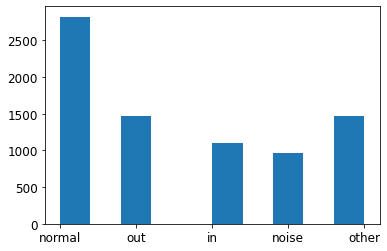

XGBOOST


In [172]:
def make_test_csv(model,submit_test,model_name,reshape=False):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
    pred = model.predict(submit_te)
    print(pred.shape)
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)
    print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
    plt.hist(np.array(submit_pd))
    plt.show()
    
    MODEL_SAVE_FOLDER_PATH = './result_csv/' 
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[:-5]+'.csv')
    print(model_name)
    return submit_pd

submit_pd = make_test_csv(xgb,submit_test[:,:100],'XGBOOST',reshape =False)

acc :  0.8919642857142858


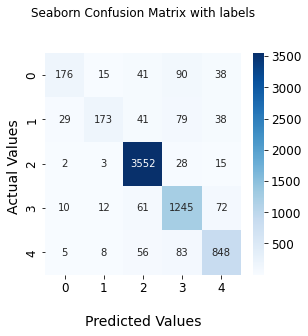

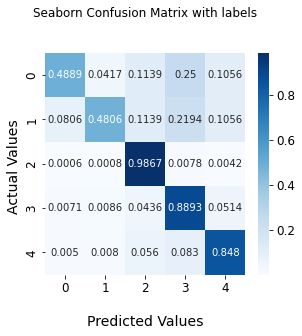

In [162]:
print_acc_knn(xgb,X_test,y_test)

X_train
X_train .shape :  (26880, 319)
X_test
X_test .shape :  (6720, 319)
y_train
y_train .shape :  (26880,)
y_test
y_test .shape :  (6720,)
[0 4 4 ... 4 2 3]
acc :  0.9038690476190476


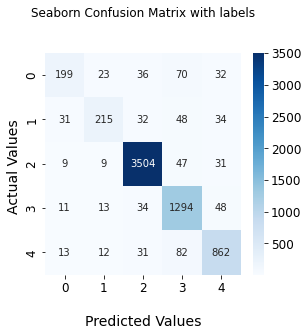

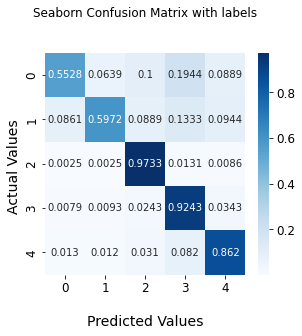

In [197]:

data_shape([X_train,X_test,y_train,y_test])
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
print(pred)
print_acc_knn(neigh,X_test)


## knn

In [25]:

data_shape([X_train,X_test,y_train,y_test])
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
neigh.predict(X_test)


X_train .shape :  (26880, 513)
X_test .shape :  (6720, 513)
y_train .shape :  (26880,)
y_test .shape :  (6720,)


array([0, 4, 4, ..., 4, 2, 3], dtype=int64)

In [42]:
def print_acc_knn(model, X_te, y_test = y_test, matrix =True):
#     y_pred = np.argmax(model.predict(X_te),axis =1)
    y_pred = model.predict(X_te)
    acc= len(y_pred[y_pred==y_test])/len(y_pred)
    print('acc : ', acc)
    cf = confusion_matrix(y_test, y_pred)

    per_cf =[]
    for i in cf:
        per_cf.append(i/np.sum(i))
    axes=[]
#     plt.rc('font', size=10)
    for i , cf in enumerate([cf, per_cf]):
        fig=plt.figure(figsize=(8,8))
        axes.append(fig.add_subplot(2,2,i+1))
        ax = sns.heatmap(np.round(cf,4),annot=True, fmt='', cmap='Blues')#확률로 표시
        ax.set_title('Seaborn Confusion Matrix with labels\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');
        fig.tight_layout()
        ## Display the visualiztion of the Confusion Matrix.
        plt.show()
        
# print_acc_knn(neigh,X_test)

X_train .shape :  (26880, 513)
X_test .shape :  (6720, 513)
y_train .shape :  (26880,)
y_test .shape :  (6720,)
[0 4 4 ... 2 2 3]
acc :  0.9145833333333333


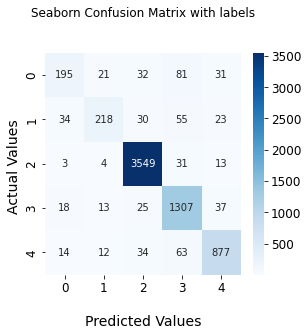

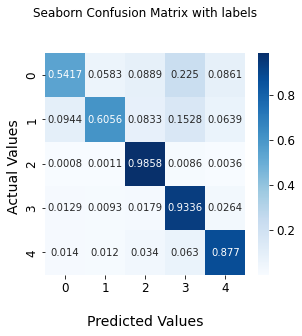

In [27]:
#scaled된 걸로


data_shape([X_train,X_test,y_train,y_test])
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_scaled, y_train)
pred = neigh.predict(X_test_scaled)
print(pred)
print_acc_knn(neigh,X_test_scaled)

X .shape :  (33600, 513)
y .shape :  (33600,)
acc :  0.9412202380952381


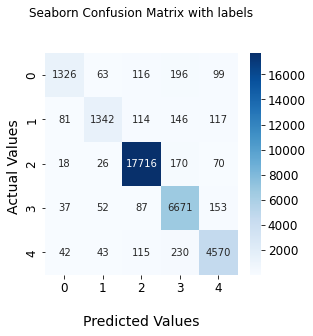

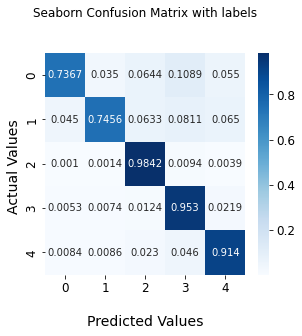

In [43]:
#scaled  x train 전부로
data_shape([X,y])
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X, y)
print_acc_knn(neigh,X,y)

X .shape :  (33600, 513)
y .shape :  (33600,)
[3 3 0 ... 4 4 4]
acc :  0.9472321428571429


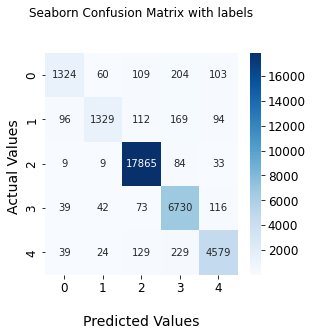

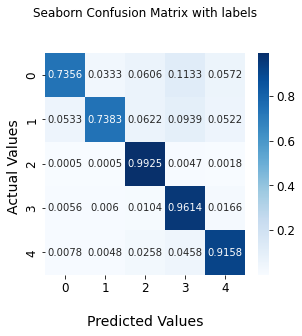

In [41]:
#scaled된 걸로  train 전부로
data_shape([X,y])
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_scaled_all, y)
print_acc_knn(neigh,X_scaled_all,y)

## in out 만

In [ ]:
#scaled된 걸로
data_shape([X_train],X_test,y_train,y_test])
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_scaled, y_train)
pred = neigh.predict(X_test_scaled)
print(pred)
print_acc_knn(neigh,X_test_scaled)

[0 1 2 3 4]
(7820,)
제출 할 csv 클래스 별 분포 :  leaktype
normal      2790
other       1615
out         1377
in          1089
noise        949
dtype: int64


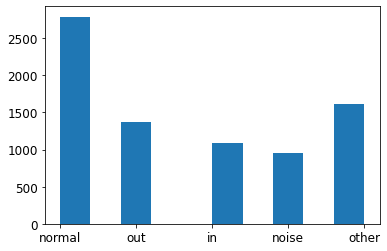

knn


In [32]:
def make_test_csv_knn(model,model_name,reshape=False,scaled=True):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    
    if reshape == True:
        submit_te = submit_test.reshape((-1,27,19,1))
    else:
        submit_te=submit_test
        
    if scaled ==True:
        submit_te = X_submit_scaled
#     pred = np.argmax(model.predict(submit_te),axis = 1)
    pred = model.predict(submit_te)
    print(np.unique(pred))
    print(pred.shape)
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)
    print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
    plt.hist(np.array(submit_pd))
    plt.show()
    
    MODEL_SAVE_FOLDER_PATH = './result_csv/' 
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
        os.mkdir(MODEL_SAVE_FOLDER_PATH) 
    submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name+'.csv')
    print(model_name)
    return submit_pd

submit_pd = make_test_csv_knn(neigh,'knn')

In [34]:
# data_shape([X_train,X_test,y_train,y_test])
# from sklearn.neighbors import RadiusNeighborsClassifier
# neigh = RadiusNeighborsClassifier(n_neighbors=5)
# neigh.fit(X_scaled, y_train)
# pred = neigh.predict(X_test_scaled)
# print(pred)
# print_acc_knn(neigh,X_test_scaled)

## scaled된 데이터로 돌림

In [72]:
batch_size= 64
X_train
model = keras.models.Sequential([
    keras.Input(shape=(27,19,1)),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(5, activation='softmax') #Output layer
    ])

model.summary()
train_model(model,X_train = X_scaled, X_test = X_test_scaled,
            batch_size = batch_size,patience = 15,optimizer = 'sgd',reshape=True,class_weight=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_20 (Batc (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_21 (Batc (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 9, 64)         25664     
_________________________________________________________________
batch_normalization_22 (Batc (None, 13, 9, 64)         256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 4, 64)         

IndexError: tuple index out of range

(7820,)
클래스 별 분포 :  leaktype
normal      2630
out         1407
in          1337
other       1309
noise       1137
dtype: int64
2022-06-14_11_20


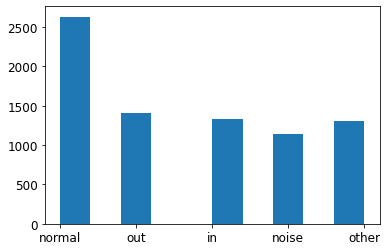

(array([ 1800.,     0.,  1800.,     0.,     0., 18000.,     0.,  7000.,
            0.,  5000.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

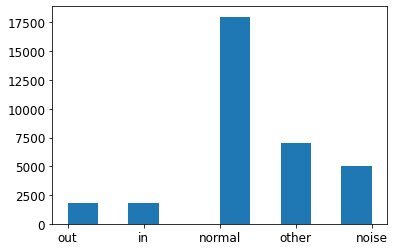

In [118]:
submit_pd = make_test_csv(model,'2022-06-14_11_20.hdf5')
plt.hist(np.array(submit_pd))
plt.show()
plt.hist(np.array(train_pd['leaktype']))



In [107]:
submit_pd.to_csv('all_noraml.csv')


In [115]:
submit_pd.iloc[:,0] = 'noise'
submit_pd.to_csv('result_csv/all_noise.csv')
submit_pd


,leaktype
id,
gAbuQeZQCm,noise
4xtuwcJQI7,noise
2LgOPmQb8u,noise
b6zEYLjs7Y,noise
yaYY68O0xX,noise
...,...
ljOCzcR8HX,noise
SdKATDrV3C,noise
Lo3sZiFiew,noise


In [72]:
sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
sample_pd.set_index('id',inplace=True)
pred = np.argmax(model.predict(submit_test),axis = 1)
pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])

print(pred)
print(pred.shape)
sub = pd.concat([test_pd.iloc[:,0],
                       pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)

sub.set_index('id',inplace=True)
# submit_pd = sub.reindex(sample_pd.index)

(7820,)


In [79]:
sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
sample_pd.set_index('id',inplace=True)
print(pred.shape)
sub = pd.concat([test_pd.iloc[:,0],
                       pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)

sub.set_index('id',inplace=True)


(7820,)


In [89]:
submit_pd = sub.reindex(sample_pd.index)


In [74]:
print(sub)
print(submit_pd)

           leaktype
id                 
A8omWrwmLF   normal
XEVCsLi6ps   normal
cEVCc0xZkC      out
M2a2qkpvQ4      out
Sts4cwqBEo   normal
...             ...
XPZiUyQPgg   normal
fLSro59Y12      out
C3guvrwoiN   normal
aU6pSfYjZG   normal
4eYAuaAagi   normal

[7820 rows x 1 columns]
           leaktype
id                 
gAbuQeZQCm   normal
4xtuwcJQI7      out
2LgOPmQb8u   normal
b6zEYLjs7Y       in
yaYY68O0xX   normal
...             ...
ljOCzcR8HX    noise
SdKATDrV3C      out
Lo3sZiFiew    noise
UxLU3Wlfxq   normal
j2s7W4bq9t   normal

[7820 rows x 1 columns]


In [81]:
submit_pd.value_counts()

leaktype
normal      2630
out         1407
in          1337
other       1309
noise       1137
dtype: int64

In [68]:
def make_test_csv(model):
    sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
    sample_pd.set_index('id',inplace=True)
    print(pred.shape)
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)

    
    submit_pd.to_csv(model_name[:-5]+'.csv')
    
def load_model_list():
    for dirname,_, filenames in os.walk('./model'):
        model_list= filenames
        print(filenames)


In [11]:
test_pd.iloc[:]

,id,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,...,5030HZ,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ
0,A8omWrwmLF,0,4,4,4,5,4,4,5,4,...,6,5,5,7,5,5,5,5,5,6
1,XEVCsLi6ps,0,8,7,10,10,10,10,10,10,...,14,14,11,13,11,13,13,11,11,11
2,cEVCc0xZkC,0,0,0,0,3,0,0,0,0,...,3,0,0,3,3,0,0,3,0,0
3,M2a2qkpvQ4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
4,Sts4cwqBEo,0,4,4,5,5,6,9,5,7,...,7,8,6,5,7,5,7,7,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,XPZiUyQPgg,0,3,4,3,4,3,4,4,3,...,5,5,5,5,7,5,5,6,5,5
7816,fLSro59Y12,0,10,12,13,20,42,37,26,26,...,10,10,7,10,10,9,9,9,10,10
7817,C3guvrwoiN,0,4,4,4,4,4,4,5,4,...,7,7,7,6,7,6,6,5,6,6
7818,aU6pSfYjZG,0,8,7,10,10,9,7,9,9,...,10,13,16,15,15,17,18,17,11,13


In [64]:



# for dirname,_, filenames in os.walk('./model'):
#     model_list= filenames
#     print(filenames)

# for model_name in model_list:
    model = tf.keras.models.load_model('./model/'+model_name)
    pred = np.argmax(model.predict(submit_test),axis = 1)
    print(pred.shape)
    sub = pd.concat([test_pd.iloc[:,0],
                           pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)
    
    sub.set_index('id',inplace=True)
    submit_pd = sub.reindex(sample_pd.index)

    
    submit_pd.to_csv(model_name[:-5]+'.csv')    

IndentationError: unexpected indent (171268613.py, line 9)

In [160]:
# submit_pd.set_index('id',inplace = True)
submit_pd

,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,noise
2LgOPmQb8u,normal
b6zEYLjs7Y,in
yaYY68O0xX,normal
...,...
ljOCzcR8HX,other
SdKATDrV3C,out
Lo3sZiFiew,in


In [156]:
sub = submit_pd.reindex(sample_pd.index)
sub

,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,noise
2LgOPmQb8u,normal
b6zEYLjs7Y,in
yaYY68O0xX,normal
...,...
ljOCzcR8HX,other
SdKATDrV3C,out
Lo3sZiFiew,in


In [155]:
# sample_pd.set_index('id',inplace=True)
sample_pd.index

Index(['gAbuQeZQCm', '4xtuwcJQI7', '2LgOPmQb8u', 'b6zEYLjs7Y', 'yaYY68O0xX',
       'Cm51xFfx5T', 'PhMYzxaU8g', 'mQC0fIQitv', 'Z57MnxcNXU', 'RscbyT87rY',
       ...
       'S4kROWP1b4', 'fd8Um3KyYl', 'PGogztirV0', 'QAXu8SEHS6', 'LIRsuyGrlC',
       'ljOCzcR8HX', 'SdKATDrV3C', 'Lo3sZiFiew', 'UxLU3Wlfxq', 'j2s7W4bq9t'],
      dtype='object', name='id', length=7820)

In [149]:
sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
# for i in sample_pd['id']:
#     print(i)
#     print(submit_pd[submit_pd['id']==i].iloc[0,1])
#     label = submit_pd[i]

In [82]:
pred =pred.reshape((1,-1))
pred.shape


(1, 7820)

In [75]:
pred=pred.tolist()
pred.type

AttributeError: 'list' object has no attribute 'type'

In [85]:
submit_pd = test_pd.iloc[:,0]
submit_pd
# pred=pred.tolist()
submit_pd['leaktype']= pred[0]
submit_pd


C:\Users\GJ\AppData\Local\Temp\ipykernel_25456\1996724392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit_pd['leaktype']= pred[0]


0                                                  A8omWrwmLF
1                                                  XEVCsLi6ps
2                                                  cEVCc0xZkC
3                                                  M2a2qkpvQ4
4                                                  Sts4cwqBEo
                                  ...                        
7816                                               fLSro59Y12
7817                                               C3guvrwoiN
7818                                               aU6pSfYjZG
7819                                               4eYAuaAagi
leaktype    [2, 2, 0, 4, 2, 2, 3, 3, 1, 2, 2, 3, 1, 2, 3, ...
Name: id, Length: 7821, dtype: object

In [46]:
test_pd


,id,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,...,5030HZ,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ
0,A8omWrwmLF,0,4,4,4,5,4,4,5,4,...,6,5,5,7,5,5,5,5,5,6
1,XEVCsLi6ps,0,8,7,10,10,10,10,10,10,...,14,14,11,13,11,13,13,11,11,11
2,cEVCc0xZkC,0,0,0,0,3,0,0,0,0,...,3,0,0,3,3,0,0,3,0,0
3,M2a2qkpvQ4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
4,Sts4cwqBEo,0,4,4,5,5,6,9,5,7,...,7,8,6,5,7,5,7,7,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,XPZiUyQPgg,0,3,4,3,4,3,4,4,3,...,5,5,5,5,7,5,5,6,5,5
7816,fLSro59Y12,0,10,12,13,20,42,37,26,26,...,10,10,7,10,10,9,9,9,10,10
7817,C3guvrwoiN,0,4,4,4,4,4,4,5,4,...,7,7,7,6,7,6,6,5,6,6
7818,aU6pSfYjZG,0,8,7,10,10,9,7,9,9,...,10,13,16,15,15,17,18,17,11,13


In [42]:
submit_pd

0       normal
1       normal
2          out
3        noise
4       normal
         ...  
7815    normal
7816     noise
7817    normal
7818    normal
7819    normal
Name: id, Length: 7820, dtype: object

In [17]:
test_pd.to_csv(model_name[:-5]+'.csv')

In [18]:
test_pd

,id,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,...,5030HZ,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ
0,2,0,4,4,4,5,4,4,5,4,...,6,5,5,7,5,5,5,5,5,6
1,2,0,8,7,10,10,10,10,10,10,...,14,14,11,13,11,13,13,11,11,11
2,0,0,0,0,0,3,0,0,0,0,...,3,0,0,3,3,0,0,3,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
4,2,0,4,4,5,5,6,9,5,7,...,7,8,6,5,7,5,7,7,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,2,0,3,4,3,4,3,4,4,3,...,5,5,5,5,7,5,5,6,5,5
7816,4,0,10,12,13,20,42,37,26,26,...,10,10,7,10,10,9,9,9,10,10
7817,2,0,4,4,4,4,4,4,5,4,...,7,7,7,6,7,6,6,5,6,6
7818,2,0,8,7,10,10,9,7,9,9,...,10,13,16,15,15,17,18,17,11,13


In [8]:


pred = np.argmax(model.predict(submit_test),axis = 1)

test_pd.iloc[:,0]= pred

for dirname,_, filenames in os.walk('./model'):
    model_list= filenames
    print(filenames)

for model_name in model_list:
    loaded_model = tf.keras.models.load_model('./model/'+model_name)
    acc = loaded_model.evaluate(submit_test,y_test)
    print(model_name)
    print(acc)
    test_pd.iloc[:,0]= pred

NameError: name 'model' is not defined

In [ ]:
#LeNet-5 구조 -> maxpool 추가
batch_size = 64

input_layer = keras.Input(shape = (513,1))
x=keras.layers.Conv1D(16, kernel_size=7, activation='relu', padding='same')(input_layer) #C11
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x=tf.keras.layers.MaxPool1D()(x)
# x=keras.layers.Conv1D(128, kernel_size=5, strides=1, activation='tanh', padding='valid')(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(84, activation='tanh')(x)
out = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer,out)
model.summary()

train_model(model,batch_size,patience = 10)